In [1]:
%cd Growing-Neural-Cellular-Automata

/home/pesquisavcl/pesquisa/filipe/automatos/Growing-Neural-Cellular-Automata


In [2]:
%matplotlib inline
import time
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output

from lib.CAModel import CAModel, LCAModel, CCAModel, SAModel,mCAModel_v7
from lib.utils_vis import SamplePool, to_alpha, to_rgb, get_living_mask, make_seed, make_circle_masks
import torch
import os


In [3]:

def load_emoji(path="C:/Users/andre/OneDrive/Imagens/gato_png.png", target_size=40):
    
    im = imageio.imread(path, pilmode='RGBA')  
    emoji = np.array(im.astype(np.float32))
    emoji = cv2.resize(emoji, (target_size, target_size))
    emoji /= 255.0
    return emoji


def visualize_batch(x0, x):
    vis0 = to_rgb(x0)
    vis1 = to_rgb(x)
    print('batch (before/after):')
    plt.figure(figsize=[15,5])
    for i in range(x0.shape[0]):
        plt.subplot(2,x0.shape[0],i+1)
        plt.imshow(vis0[i])
        plt.axis('off')
    for i in range(x0.shape[0]):
        plt.subplot(2,x0.shape[0],i+1+x0.shape[0])
        plt.imshow(vis1[i])
        plt.axis('off')
    plt.show()

def plot_loss(loss_log):
    plt.figure(figsize=(10, 4))
    plt.title('Loss history (log10)')
    plt.plot(np.log10(loss_log), '.', alpha=0.1)
    plt.show()

In [4]:
device = torch.device("cuda:0")
# model_checkpoint_folder = "checkpoint/"

CHANNEL_N = 16   # Number of CA state channels
TARGET_PADDING = 0   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
hidden_size = 62

lr = 2e-3
lr_gamma = 0.9999
betas = (0.5, 0.5)
# n_epoch = 5000
n_epoch = 200

BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5 #testar com 1.0

step_min = 64
step_max = 96


EXPERIMENT_TYPE = "Growing"

path_input_img = 'data/urso.jpg'

exp_name = "temp"

output_folder = 'outputs'


In [5]:
# Parameters
exp_name = "urso_nca_ts60_hs82_ep20k"
path_input_img = "data/urso.jpg"
CHANNEL_N = 16
TARGET_PADDING = 0
TARGET_SIZE = 60
hidden_size = 82
lr = 0.002
lr_gamma = 0.9999
n_epoch = 20000
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5
EXPERIMENT_TYPE = "Growing"
output_folder = "outputs"


In [6]:
#Dependent parameters

EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch


# exp_name = f"{exp_name}_hs{hidden_size}_ts{TARGET_SIZE}"
output_path = os.path.join(output_folder,exp_name)
                           
if not os.path.exists(output_path): 
    # if the folder directory is not present  
    # then create it. 
    os.makedirs(output_path) 
    
# model_folder = "models/compressNCA_temp1.pth"
model_folder = os.path.join(output_path,'models')

if not os.path.exists(model_folder): 
    # if the folder directory is not present  
    # then create it. 
    os.makedirs(model_folder) 


(60, 60, 4)


/tmp/ipykernel_513543/2050698433.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(path, pilmode='RGBA')


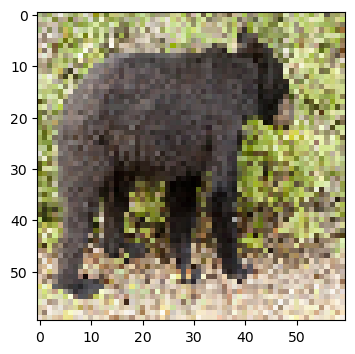

In [7]:
# model_path = "models/compressNCA_temp1.pth"
model_path = os.path.join(model_folder,'temp1.pth')

target_img = load_emoji(path=path_input_img, target_size=TARGET_SIZE)
plt.figure(figsize=(4,4))
print(target_img.shape)
if target_img.shape[2] >3:
    plt.imshow(to_rgb(target_img))
else:
    plt.imshow(target_img)
plt.show()


In [8]:

_25425p = TARGET_PADDING
pad_target = np.pad(target_img, [(_25425p, _25425p), (_25425p, _25425p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)

#Filipe update
# pad_target = torch.from_numpy(pad_target.astype(np.float32)).to(device) #
pad_target = torch.from_numpy(np.repeat(pad_target, BATCH_SIZE, axis=0).astype(np.float32)).to(device)


seed = make_seed((h, w), CHANNEL_N)
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
batch = pool.sample(BATCH_SIZE).x

#ca = mCAModel_v7(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=hidden_size).to(device)
ca = CAModel(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=hidden_size).to(device)
# ca = CAModel(22, CELL_FIRE_RATE, device,hidden_size=62).to(device)


# mp = "models/remaster_uv71.pth"
# mp = "models/remaster_uv72.pth"
# mp = "models/remaster_uv73.pth"
# ca.load_state_dict(torch.load(mp))

optimizer = optim.Adam(ca.parameters(), lr=lr, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)

In [9]:
from torchsummary import summary


summary(ca, (TARGET_SIZE, TARGET_SIZE, CHANNEL_N))
# summary(ca, (40, 40, 22))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 60, 60, 82]           4,018
            Linear-2           [-1, 60, 60, 16]           1,312
Total params: 5,330
Trainable params: 5,330
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.22
Forward/backward pass size (MB): 2.69
Params size (MB): 0.02
Estimated Total Size (MB): 2.93
----------------------------------------------------------------


20000 loss = 0.008029663935303688
batch (before/after):


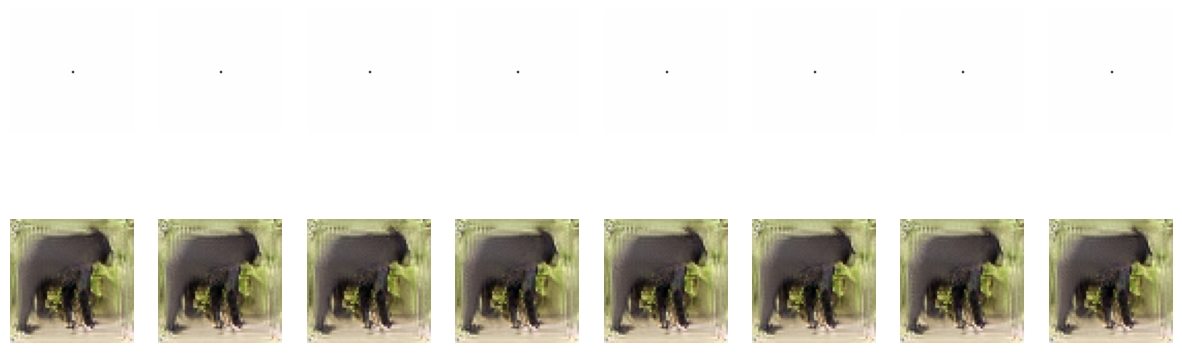

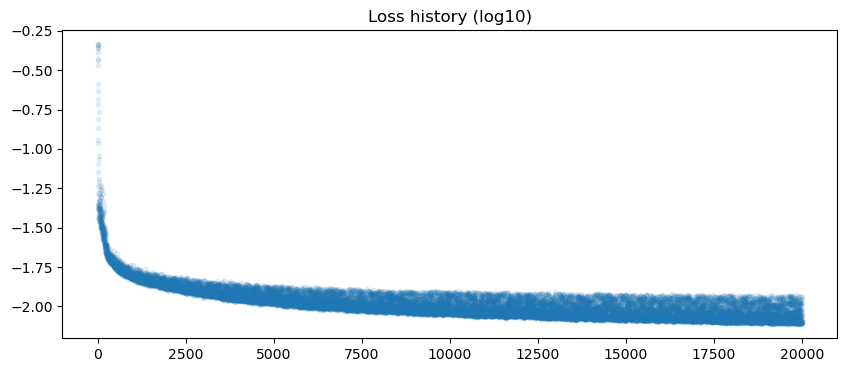

In [10]:
loss_log = []
best_loss = 9999999
def train(x, target, steps, optimizer, scheduler):
    x = ca(x, steps=steps)
    #import pdb;pdb.set_trace()
    if target.shape[-1]>3:
        loss = F.mse_loss(x[:, :, :, :4], target)
    else:
        loss = F.mse_loss(x[:, :, :, :3], target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    return x, loss

def loss_f(x, target):
    if target.shape[-1]>3:
        return torch.mean(torch.pow(x[..., :4]-target, 2), [-2,-3,-1])
    else:
        return torch.mean(torch.pow(x[..., :3]-target, 2), [-2,-3,-1])

for i in range(n_epoch+1):

    if USE_PATTERN_POOL:
        batch = pool.sample(BATCH_SIZE)
        x0 = torch.from_numpy(batch.x.astype(np.float32)).to(device)
        loss_rank = loss_f(x0, pad_target).detach().cpu().numpy().argsort()[::-1]
        x0 = batch.x[loss_rank]
        x0[:1] = seed
        if DAMAGE_N:
            damage = 1.0-make_circle_masks(DAMAGE_N, h, w)[..., None]
            x0[-DAMAGE_N:] *= damage
    else:
        x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
    x0 = torch.from_numpy(x0.astype(np.float32)).to(device)

    #x, loss = train(x0, pad_target, np.random.randint(64,96), optimizer, scheduler)
    x, loss = train(x0, pad_target, np.random.randint(step_min,step_max), optimizer, scheduler)

        
    if USE_PATTERN_POOL:
        batch.x[:] = x.detach().cpu().numpy()
        batch.commit()

    step_i = len(loss_log)
    loss_log.append(loss.item())

    if step_i%100 == 0:
        clear_output()
        print(step_i, "loss =", loss.item())
        visualize_batch(x0.detach().cpu().numpy(), x.detach().cpu().numpy())
        plot_loss(loss_log)
        if loss.item() < best_loss:
            print(f"Saving model... {loss.item()} < {best_loss}") 
            best_loss = loss.item()
            torch.save(ca.state_dict(), model_path)

## Generate image with inference

In [11]:
import tqdm

#loaded_ca = mCAModel_v7(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=hidden_size).to(device)
loaded_ca = CAModel(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=hidden_size).to(device)

loaded_ca.load_state_dict(torch.load(model_path))

x = np.zeros([1, TARGET_SIZE, TARGET_SIZE, CHANNEL_N], np.float32)

x0 = np.repeat(seed[None, ...], 1, 0)
x0 = torch.from_numpy(x0.astype(np.float32)).to(device)

#xf = loaded_ca(x0,steps=96)
xf = loaded_ca(x0,steps=step_max)

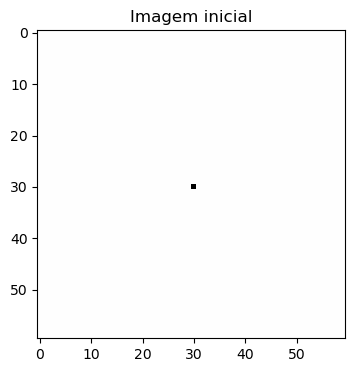

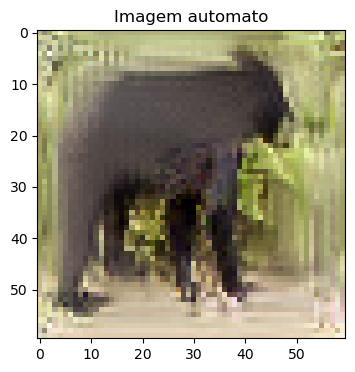

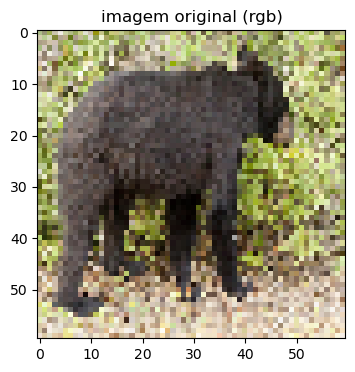

In [12]:
#Filipe's code
input_rgb = to_rgb(x0.detach().cpu().numpy())
output_rgb = to_rgb(xf.detach().cpu().numpy())
target_rgb = to_rgb(target_img)

#unpading
output_image = output_rgb[0]
unpad_output_image = output_image[TARGET_PADDING:output_image.shape[0]-TARGET_PADDING, TARGET_PADDING:output_image.shape[1]-TARGET_PADDING]


plt.figure(figsize=(4,4))
plt.imshow(input_rgb[0])
plt.title("Imagem inicial")

plt.figure(figsize=(4,4))
plt.imshow(unpad_output_image)
plt.title("Imagem automato")

plt.figure(figsize=(4,4))
plt.imshow(to_rgb(target_img))
plt.title("imagem original (rgb)")
plt.show()

In [13]:
from PIL import Image

# path_img_automato = "data/mca_v7_urso40_h62.png"
path_img_automato = os.path.join(output_path, 'automato.png')
#path_original = "data/target_mca_urso40.png"
path_original = os.path.join(output_path, 'target.png')

unpad_output_image_ = unpad_output_image * 255
unpad_output_image_ = unpad_output_image_.astype(np.uint8)
im = Image.fromarray(unpad_output_image_)
#im.save("data/automato_cca.png", "PNG")
im.save(path_img_automato, "PNG")


temp = to_rgb(target_img)* 255
temp_ = temp.astype(np.uint8)
im2 = Image.fromarray(temp_)
# im2 = Image.fromarray(target_img)
#im2.save("data/target_cca.png", "PNG")
im2.save(path_original, "PNG")

In [14]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from skimage.io import imread


imagem_automato = imread(path_img_automato)
imagem_original = imread(path_original)

mse = mean_squared_error(imagem_original, imagem_automato)
psnr = peak_signal_noise_ratio(imagem_original, imagem_automato)
ssim = structural_similarity(imagem_original, imagem_automato, win_size=3, multichannel=True)


print("[automato]PSNR (Peak Signal-to-Noise Ratio):", psnr)
print("[automato]MSE (Mean Squared Error):", mse)
print("[automato]SSIM (Structural Similarity Index):", ssim)



def tamanho_arquivo(caminho):
    # return os.path.getsize(caminho)
    #print(os.stat(caminho).st_size)
    return os.stat(caminho).st_size



#tamanho_original = tamanho_arquivo(caminho_img_original)
tamanho_original = tamanho_arquivo(path_original)
#tamanho_automato = tamanho_arquivo(caminho_img_automato)
tamanho_automato = tamanho_arquivo(path_img_automato)


print("Tamanho da imagem original:", tamanho_original, "bytes")
print("Tamanho da imagem gerada pelo autômato:", tamanho_automato, "bytes")

def calcular_bits_por_pixel(caminho_imagem, tamanho_arquivo):
    imagem = imread(caminho_imagem)
    largura, altura, _ = imagem.shape
    total_pixels = largura * altura
    bits_por_pixel = (tamanho_arquivo * 8) / total_pixels
    return bits_por_pixel

#bits_por_pixel_original = calcular_bits_por_pixel(caminho_img_original, tamanho_original)
bits_por_pixel_original = calcular_bits_por_pixel(path_original, tamanho_original)
#bits_por_pixel_automato = calcular_bits_por_pixel(caminho_img_automato, tamanho_automato)
bits_por_pixel_automato = calcular_bits_por_pixel(path_img_automato, tamanho_automato)

print("Bits por Pixel da imagem original:", bits_por_pixel_original)
print("Bits por Pixel da imagem gerada pelo autômato:", bits_por_pixel_automato)



# Calculando jpeg para comparação
print("#"*10)
print("\nJPEG...")

from PIL import Image

size = TARGET_SIZE
# im = Image.open("data/trem.jpg")
path_input_img
im = Image.open(path_input_img).resize((size,size))
rgb_im = im.convert('RGB')
path_img_jpg = os.path.join(output_path, 'jpeg.jpg')
#rgb_im.save('data/urso40.jpg', quality=95)
rgb_im.save(path_img_jpg, quality=95)
imagem_jpeg = imread(path_img_jpg)

mse = mean_squared_error(imagem_original, imagem_jpeg)
psnr = peak_signal_noise_ratio(imagem_original, imagem_jpeg)
ssim = structural_similarity(imagem_original, imagem_jpeg, win_size=3, multichannel=True)
tamanho_jpeg = tamanho_arquivo(path_img_jpg)

print("[jpeg]PSNR (Peak Signal-to-Noise Ratio):", psnr)
print("[jpeg]MSE (Mean Squared Error):", mse)
print("[jpeg]SSIM (Structural Similarity Index):", ssim)
print("Tamanho da imagem original:", tamanho_original, "bytes")
print("Tamanho da imagem gerada pelo jpeg:", tamanho_jpeg, "bytes")



[automato]PSNR (Peak Signal-to-Noise Ratio): 19.810738028809357
[automato]MSE (Mean Squared Error): 679.2138888888888
[automato]SSIM (Structural Similarity Index): 0.6673051687057522
Tamanho da imagem original: 10075 bytes
Tamanho da imagem gerada pelo autômato: 8150 bytes
Bits por Pixel da imagem original: 22.38888888888889
Bits por Pixel da imagem gerada pelo autômato: 18.11111111111111
##########

JPEG...
[jpeg]PSNR (Peak Signal-to-Noise Ratio): 19.763879240236548
[jpeg]MSE (Mean Squared Error): 686.582037037037
[jpeg]SSIM (Structural Similarity Index): 0.6988804211075874
Tamanho da imagem original: 10075 bytes
Tamanho da imagem gerada pelo jpeg: 3385 bytes
